In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("../data/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [4]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

In [6]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
df = df[df["price"] <=1000]

In [8]:
df.shape

(48656, 16)

In [9]:
df.loc[:,"price"] = np.log1p(df["price"])

C:\Users\siddhants\AppData\Local\Temp\ipykernel_13616\1187040555.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5.01063529 5.420535   5.01727984 ... 4.75359019 4.02535169 4.51085951]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,"price"] = np.log1p(df["price"])


In [10]:
df["last_review"].value_counts()

last_review
2019-06-23    1412
2019-07-01    1356
2019-06-30    1337
2019-06-24     872
2019-07-07     717
              ... 
2013-12-15       1
2016-11-02       1
2015-01-09       1
2014-07-12       1
2013-05-24       1
Name: count, Length: 1762, dtype: int64

In [11]:
df.loc[:,"reviews_per_month"] = df["reviews_per_month"].fillna(0)

In [12]:
df.isnull().sum()

id                                   0
name                                16
host_id                              0
host_name                           21
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9920
reviews_per_month                    0
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [13]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

In [14]:
df.loc[:, "dist_times_square_km"] = (haversine(
    df["latitude"],
    df["longitude"],
    40.7580,
    -73.9855
))

In [15]:
keywords = {
    "luxury": ["luxury", "luxurious", "high-end"],
    "view": ["view", "views", "skylit", "river"],
    "quiet": ["quiet", "peaceful", "calm"],
    "spacious": ["spacious", "large", "roomy"],
}

df.loc[:,"name"] = df["name"].fillna("").str.lower()

for feature, words in keywords.items():
    df[f"kw_{feature}"] = df["name"].apply(
        lambda x: int(any(word in x for word in words))
    )


In [16]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,dist_times_square_km,kw_luxury,kw_view,kw_quiet,kw_spacious
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,...,9,2018-10-19,0.21,6,365,12.337898,0,0,1,0
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,...,45,2019-05-21,0.38,2,355,0.508366,0,1,0,0
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,...,0,NaN,0.00,1,365,6.757240,0,0,0,0
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,...,270,2019-07-05,4.64,1,194,8.387034,0,0,0,0
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,...,9,2018-11-19,0.10,1,0,5.701496,0,0,0,1


In [17]:
# Assume 'df' is your cleaned dataframe
X = df.drop(['price', 'id', 'host_name', 'last_review'], axis=1)
y = np.log1p(df['price']) # Log transform target

In [18]:
# 1. Pipeline Setup (Professional Standard)
# We handle numeric and categorical features separately
numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']
categorical_features = ['neighbourhood_group', 'room_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

In [19]:
# spliting the dataset
X_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [20]:
models = {
    "Linear Regression" : LinearRegression(),
    "Ridge (L2)" : Ridge(alpha=10),
    "Lasso (L1)" : Lasso(alpha=0.001) # Low alpha for log-transformed targets
}

In [21]:
results = {}

print("Model Performance (Log Price):")

for name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(x_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = clf  # ✅ store pipeline correctly

    print(f"Name={name}, R2={r2:.4f}, RMSE={rmse:.4f}")



Model Performance (Log Price):
Name=Linear Regression, R2=0.4839, RMSE=0.0862
Name=Ridge (L2), R2=0.4839, RMSE=0.0862
Name=Lasso (L1), R2=0.4720, RMSE=0.0872


In [22]:
# Extracting coefficients from the Pipeline
lasso_model = results["Lasso (L1)"]['classifier']
feature_names = (results["Lasso (L1)"]['preprocessor']
                 .transformers_[0][2] + 
                 list(results["Lasso (L1)"]['preprocessor']
                      .transformers_[1][1].get_feature_names_out(categorical_features)))

coefs = pd.DataFrame(
    lasso_model.coef_,
    columns=['Coefficients'], index=feature_names
)

C:\Users\siddhants\AppData\Local\Temp\ipykernel_13616\2239847078.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficients', y=top_coefs.index, data=top_coefs, palette='coolwarm')


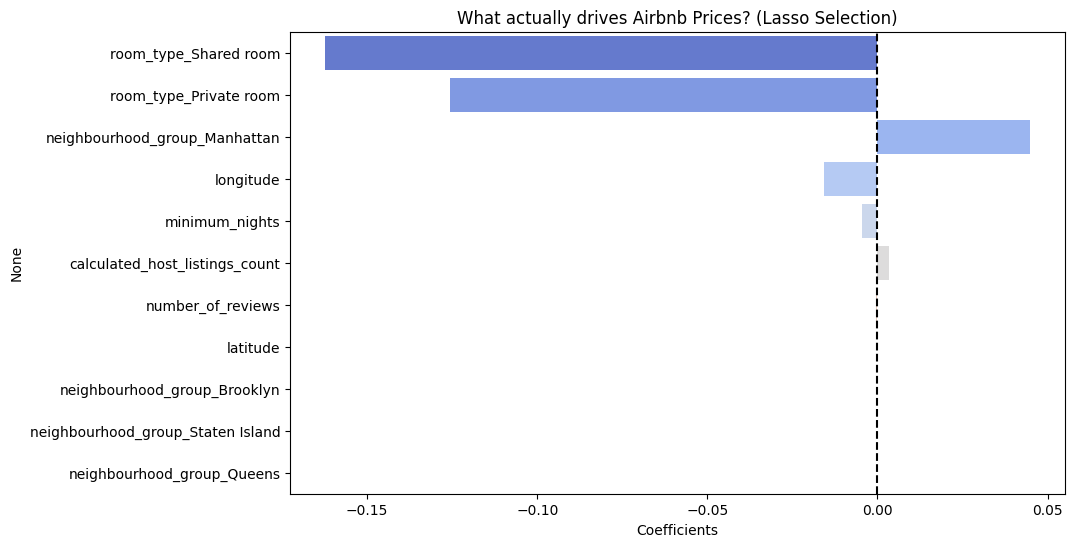

In [23]:
# Plot top 10 positive and negative features
coefs['Abs_Coeff'] = coefs['Coefficients'].abs()
top_coefs = coefs.sort_values('Abs_Coeff', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficients', y=top_coefs.index, data=top_coefs, palette='coolwarm')
plt.title("What actually drives Airbnb Prices? (Lasso Selection)")
plt.axvline(0, color='black', linestyle='--')
plt.show()